## Week 7: Simulation of the JAK2-SKE complex in implicit solvent simulations

In [ ]:
$ module load amber/openmpi/intel/22.03

In [ ]:
$ wget https://files.rcsb.org/download/5USZ.pdb

In [ ]:
# Get protein-ligand information

$ grep -vE 'GOL|DMS|CONECT' 5USZ.pdb > 5usz_complex.pdb

In [ ]:
# Use pdb4amber to prepare the PDB file
# --dry: remove crystallographic waters
# --reduce: add hydrogen atoms in their optimal locations
# The output file should contain all of the hydrogens for each of the residues

$ pdb4amber -i 5usz_complex.pdb -o 5usz_complex_h.pdb --dry --reduce

In [ ]:
$ sed 's/SKE/JNJ/g' 5usz_complex_h.pdb > 5usz_complex_new.pdb

#### Part 1: Prepare the ligang topology (SKE)

In [ ]:
$ grep "HETATM" 5usz_complex_h.pdb > jnj_h.pdb

# Manual delete other elements and only keep SKE

In [ ]:
# change the name of the residue from "SKE" to "JNJ"
# sed: This is the command for the stream editor
# s = substitution
# g = global 

$ sed 's/SKE/JNJ/g' jnj_h.pdb > jnj_new.pdb

In [ ]:
# Goal: get charges and atom types

# -i jnj_h.pdb: input 3D structure file
# -fi: pdb tells antechamber that this is a pdb format file
# -fo mol2: formate of the output file is Tripos Mol2
# -c bcc: tells antechamber to use the AM1-BCC charge model in order to calculate the atomic point charges
# -s 2: option defines the verbosity of the status information provided by antechamber.

$ antechamber -i jnj_new.pdb -fi pdb -o jnj.mol2 -fo mol2 -c bcc -s 2

In [ ]:
# utility parmchk2 to test if all the parameters we require are available
# jnj.frcmod is a parameter file that can be loaded into LEaP in order to add missing parameters

$ parmchk2 -i jnj.mol2 -f mol2 -o jnj.frcmod

In [ ]:
# Run tleap

$ tleap -f oldff/leaprc.ff99SB

In [ ]:
# Use GAFF2 force field

$ source leaprc.gaff2

In [ ]:
# load JNJ as a unit in LEaP

$ JNJ = loadmol2 jnj.mol2 

# Loading Mol2 file: ./jnj.mol2
# Reading MOLECULE named JNJ

In [ ]:
# tell tleap the parameters

$ loadamberparams jnj.frcmod

In [ ]:
# create the library file for JNJ

$ saveoff JNJ jnj.lib

In [ ]:
$ saveamberparm JNJ jnj.prmtop jnj.rst7

# Checking Unit.
# Building topology.
# Building atom parameters.
# Building bond parameters.
# Building angle parameters.
# Building proper torsion parameters.
# Building improper torsion parameters.
#  total 18 improper torsions applied
# Building H-Bond parameters.
# Incorporating Non-Bonded adjustments.
# Not Marking per-residue atom chain types.
# Marking per-residue atom chain types.
#   (Residues lacking connect0/connect1 - 
#    these don't have chain types marked:

#         res     total affected

#         JNJ     1
#   )
#  (no restraints)

In [ ]:
$ quit

# Exiting LEaP: Errors = 0; Warnings = 0; Notes = 0.

#### Part 2: Creating topology and coordinate files for JAK2-SKE complex

In [ ]:
$ tleap -f oldff/leaprc.ff99SB

In [ ]:
$ source leaprc.gaff2

In [ ]:
$ loadamberparams jnj.frcmod

In [ ]:
$ loadoff jnj.lib

In [ ]:
$ complex = loadpdb 5usz_complex_new.pdb

In [ ]:
$ set default PBRadii mbondi3

In [ ]:
$ saveamberparm complex 5usz_jnj.prmtop 5usz_jnj.rst7

#### Part 3: Minimize and Equilibrate the complex

In [ ]:
# Make a amberjob1.sbatch file

    """
#!/bin/bash

#SBATCH --job-name=Amber
#SBATCH --nodes=1
#SBATCH --tasks-per-node=20
#SBATCH --time=48:00:00
#SBATCH --mem=20GB
unset SLURM_TRES_PER_TASK

# Comments start here, above are not comments and should be in your script 
# go to your working directory: /scratch/qo210/comp-lab-class-2024/Week8_implicit  
cd /scratch/qo210/comp-lab-class-2024/Week8_implicit

# load module to run amber

module purge
module load amber/openmpi/intel/20.11 

# run minimization job
sander -O -i min.in -o 5usz_jnj_min.out -p 5usz_jnj.prmtop -c 5usz_jnj.rst7 -r 5usz_jnj_min.rst7

# run heating job
sander -O -i heat.in -o 5usz_jnj_heat.mdout -p 5usz_jnj.prmtop -c 5usz_jnj_min.rst7 -r 5usz_jnj_heat.rst7 -x heat.nc

    """

In [ ]:
   # Make a amberjob2_gpu.sbatch file
   
    """
#!/bin/bash

#SBATCH --job-name=Amber
#SBATCH --nodes=1
#SBATCH --tasks-per-node=20
#SBATCH --time=5:00:00
#SBATCH --mem=20GB
#SBATCH --gres=gpu:rtx8000:1

# Comments start here, above are not comments and should be in your script 
# go to your working directory: /scratch/qo210/comp-lab-class-2024/Week8_implicit  
cd /scratch/qo210/comp-lab-class-2024/Week8_implicit

module purge
module load amber/openmpi/intel/20.11 


# run md job
pmemd.cuda -O -i md.in -o 5usz_jnj_md_gpu.out -p 5usz_jnj.prmtop -c 5usz_jnj_heat.rst7  -r 5usz_jnj_md_gpu.rst7 -x 5usz_jnj_md_gpu.nc

    """

#### Analysis - minimization

In [ ]:
$ mkdir min_analysis 
$ cd min_analysis 
$ process_minout.perl ../5usz_jnj_min.out

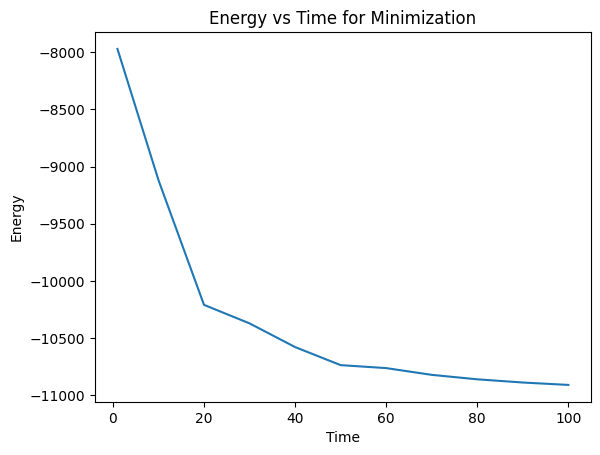

In [10]:
# summary.ENERGY is the one with total energy

import matplotlib.pyplot as plt

# Specify the file path
file_path = "min_analysis/summary.ENERGY"

# Read data from file
time = []
energy = []
with open(file_path, 'r') as file:
    for line in file:
        columns = line.split()
        time.append(float(columns[0]))
        energy.append(float(columns[1]))

# Plot the graph
plt.plot(time, energy)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time for Minimization')
plt.show()


#### Analysis - Heating

In [ ]:
$ mkdir heat_analysis 
$ cd heat_analysis 
$ process_mdout.perl ../5usz_jnj_heat.mdout

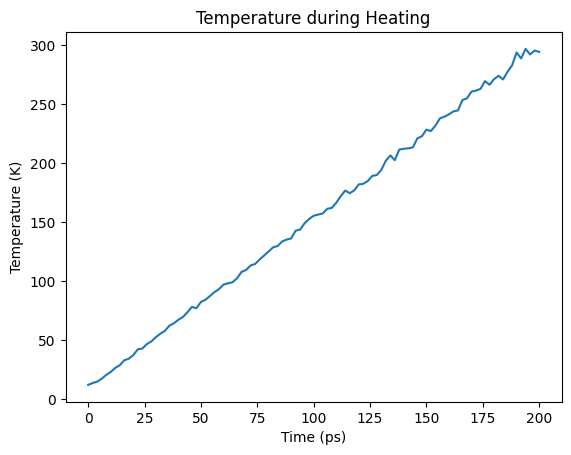

In [12]:
# Plot temperature of the system over the equilibration phase

file_path = "heat_analysis/summary.TEMP"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'temperature'])

# Plot the graph
plt.plot(data['time'], data['temperature'])
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.title('Temperature during Heating')
plt.show()

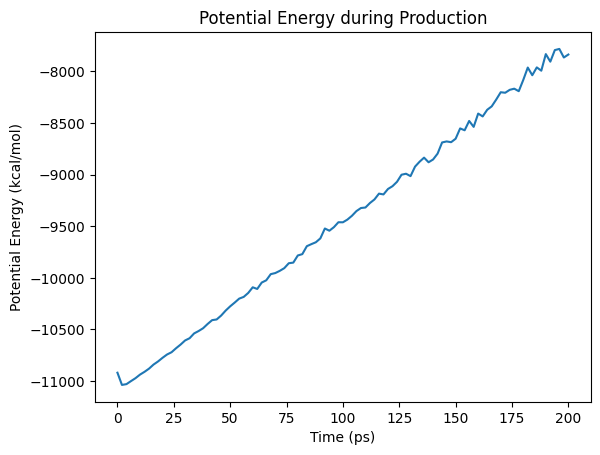

In [13]:
# Graph potential energy of the system throughout production

file_path = "heat_analysis/summary.EPTOT"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'potential_energy'])

# Plot the graph
plt.plot(data['time'], data['potential_energy'])
plt.xlabel('Time (ps)')
plt.ylabel('Potential Energy (kcal/mol)')
plt.title('Potential Energy during Heating')
plt.show()

#### Analysis - MD

In [ ]:
$ mkdir md_analysis 
$ cd md_analysis 
$ process_mdout.perl ../5usz_jnj_md_gpu.out

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


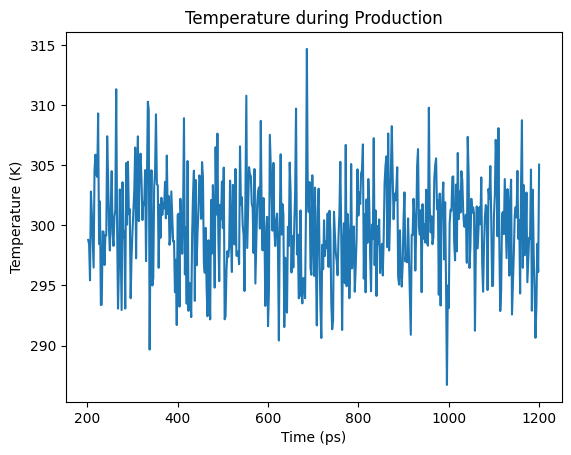

In [15]:
# Plot temperature of the system over the equilibration phase

file_path = "md_analysis/summary.TEMP"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'temperature'])

# Plot the graph
plt.plot(data['time'], data['temperature'])
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.title('Temperature during Production')
plt.show()

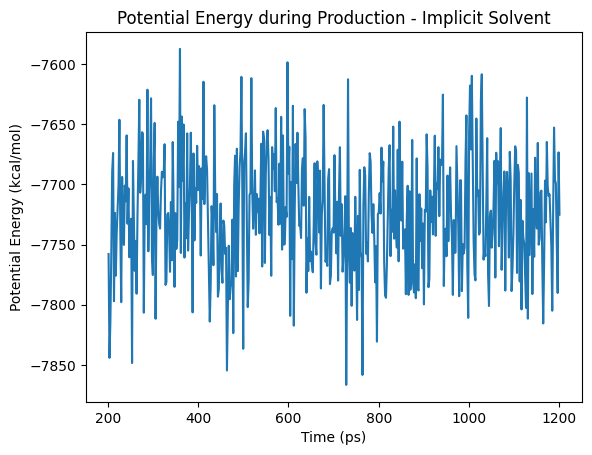

In [17]:
# Graph potential energy of the system throughout production

file_path = "md_analysis/summary.EPTOT"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'potential_energy'])

# Plot the graph
plt.plot(data['time'], data['potential_energy'])
plt.xlabel('Time (ps)')
plt.ylabel('Potential Energy (kcal/mol)')
plt.title('Potential Energy during Production - Implicit Solvent')
plt.show()

In [ ]:
# Make input file short_prod.ptraj 

    """
trajin ../5usz_jnj_md_gpu.nc 1 2000 4 
center :1-273 
image familiar 
rms first @N,CA,C 
trajout prod_2ns.mdcrd 
run
    """

In [ ]:
$ cpptraj ../5usz_jnj.prmtop short_prod.ptraj

In [ ]:
# Use cpptraj to calculate root mean square deviation (RMSD) for us as a function of time
# Make prod_rmsd.ptraj input file
# Consider just the main backbone atoms, N, CA, C.

    """
trajin prod_2ns.mdcrd 
rms first mass out prod_rmsd.out @N,CA,C time 4
run
    """
    
# @C,CA,N means using these types of atoms for rmsd calculation

In [ ]:
$ cpptraj ../5usz_jnj.prmtop prod_rmsd.ptraj

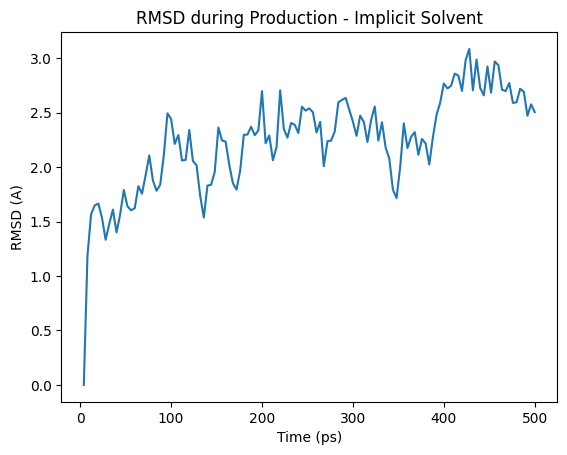

In [19]:
# The RMSD of the system throughout Minimization

file_path = "md_analysis/prod_rmsd.out"
data = pd.read_csv(file_path, sep="\s+")

# Plot the graph
plt.plot(data['#Frame'], data['RMSD_00001'])
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (A)')
plt.title('RMSD during Production - Implicit Solvent')

plt.show()